In [12]:
from environment import Environment
import numpy as np
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import tqdm

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [13]:
BATCH_SIZE = 100
LR = 0.03
GAMMA = 0.90
EPSILON = 0.9
MEMORY_CAPACITY = 10000
Q_NETWORK_ITERATION = 1000

env = Environment()
NUM_ACTIONS = env.n_actions
NUM_STATES = env.n_features
EPISODES = 20000

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(NUM_STATES, 80)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(80, NUM_ACTIONS)
        self.fc2.weight.data.normal_(0, 0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [15]:
class DQN:
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
        self.memory = np.zeros((MEMORY_CAPACITY, NUM_STATES * 2 + 2))
        self.memory_counter = 0
        self.learn_counter = 0
        self.optimizer = optim.Adam(self.eval_net.parameters(), LR)
        self.loss = nn.MSELoss()

    def store_trans(self, state, action, reward, next_state):
        index = self.memory_counter % MEMORY_CAPACITY
        trans = np.hstack((state, action, reward, next_state))
        self.memory[index, :] = trans
        self.memory_counter += 1

    def choose_action(self, state):
        state = torch.unsqueeze(torch.FloatTensor(state), 0)
        if np.random.randn() <= EPSILON:
            action_value = self.eval_net.forward(state)
            action = torch.max(action_value, 1)[1].data.numpy()
            action = action[0]
        else:
            action = np.random.randint(0, NUM_ACTIONS)
        return action

    def learn(self):
        if self.learn_counter % Q_NETWORK_ITERATION == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_counter+=1

        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        batch_memory = self.memory[sample_index, :]
        batch_state = torch.FloatTensor(batch_memory[:, :NUM_STATES])
        batch_action = torch.LongTensor(batch_memory[:, NUM_STATES:NUM_STATES+1].astype(int))
        batch_reward = torch.FloatTensor(batch_memory[:, NUM_STATES+1: NUM_STATES+2])
        batch_next_state = torch.FloatTensor(batch_memory[:, -NUM_STATES:])

        q_eval = self.eval_net(batch_state).gather(1, batch_action)
        q_next = self.target_net(batch_next_state).detach()
        q_target = batch_reward + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)

        loss = self.loss(q_eval, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

The DQN is collecting experience...


  0%|          | 0/20000 [00:00<?, ?it/s]

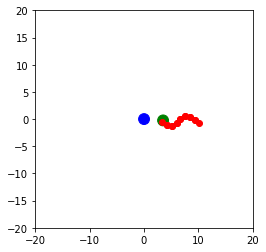

  0%|          | 81/20000 [00:00<01:37, 204.79it/s]

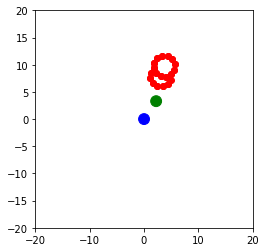

  1%|          | 193/20000 [00:01<01:28, 223.61it/s]

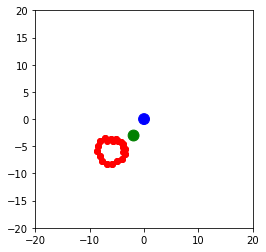

  1%|▏         | 288/20000 [00:01<01:23, 235.55it/s]

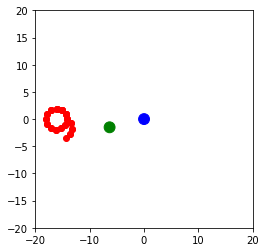

  2%|▏         | 386/20000 [00:01<01:18, 248.94it/s]

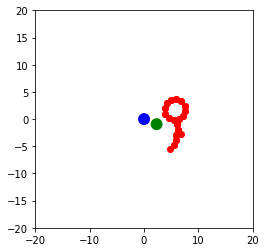

  2%|▏         | 484/20000 [00:02<01:17, 252.80it/s]

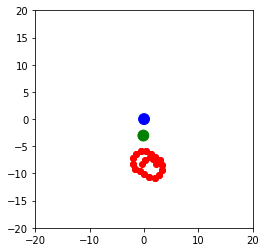

  3%|▎         | 597/20000 [00:04<06:44, 47.95it/s] 

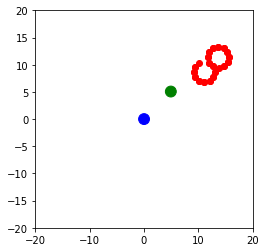

  3%|▎         | 697/20000 [00:07<08:51, 36.35it/s]

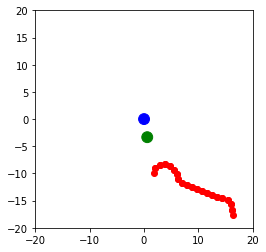

  4%|▍         | 799/20000 [00:10<08:27, 37.87it/s]

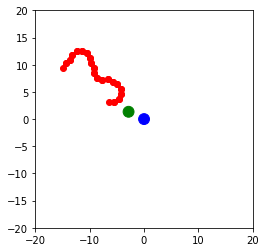

  4%|▍         | 898/20000 [00:13<08:08, 39.11it/s]

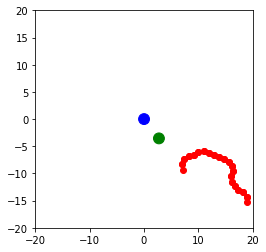

  5%|▌         | 1000/20000 [00:16<08:33, 36.97it/s]

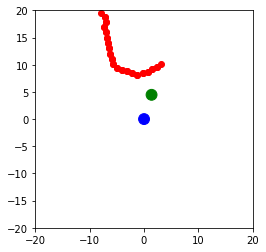

  5%|▌         | 1096/20000 [00:19<08:21, 37.66it/s]

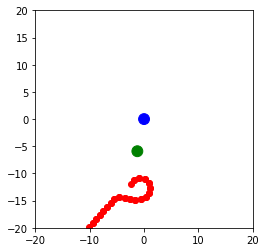

  6%|▌         | 1197/20000 [00:22<08:08, 38.52it/s]

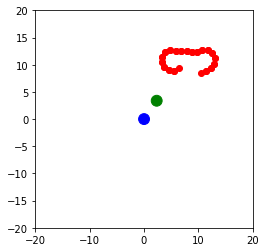

  6%|▋         | 1297/20000 [00:24<08:09, 38.21it/s]

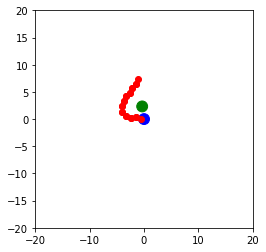

  7%|▋         | 1398/20000 [00:27<08:06, 38.20it/s]

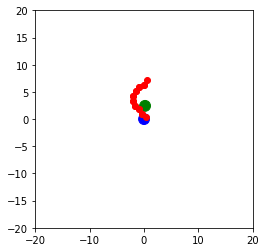

  7%|▋         | 1498/20000 [00:30<07:28, 41.21it/s]

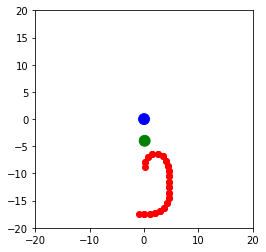

  8%|▊         | 1598/20000 [00:33<10:03, 30.47it/s]

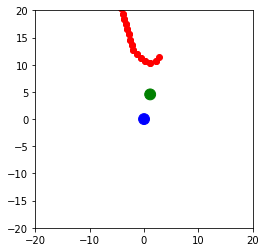

  8%|▊         | 1696/20000 [00:35<07:00, 43.48it/s]

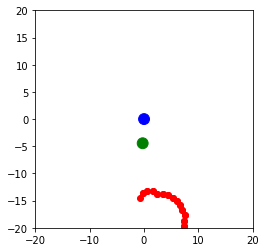

  9%|▉         | 1797/20000 [00:38<07:04, 42.93it/s]

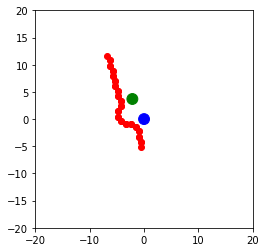

  9%|▉         | 1898/20000 [00:40<06:59, 43.14it/s]

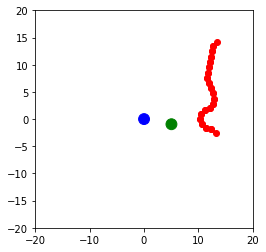

 10%|▉         | 1997/20000 [00:43<06:55, 43.28it/s]

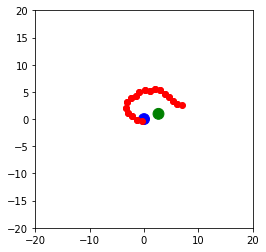

 10%|█         | 2100/20000 [00:46<07:00, 42.58it/s]

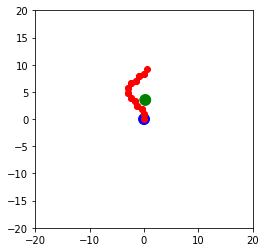

 11%|█         | 2199/20000 [00:48<07:14, 40.97it/s]

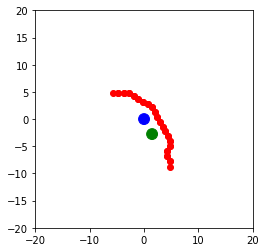

 11%|█▏        | 2299/20000 [00:51<06:25, 45.88it/s]

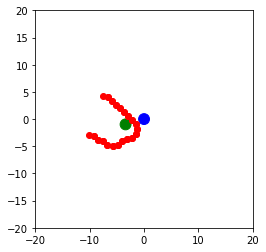

 12%|█▏        | 2398/20000 [00:53<06:19, 46.37it/s]

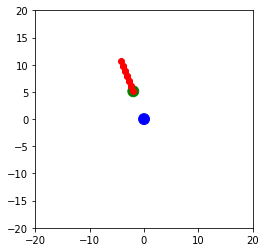

 12%|█▏        | 2498/20000 [00:56<07:30, 38.81it/s]

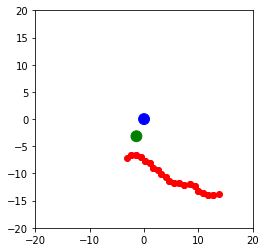

 13%|█▎        | 2599/20000 [00:58<06:08, 47.18it/s]

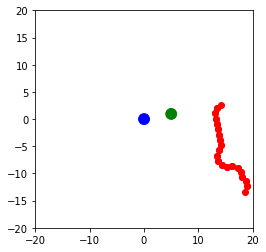

 14%|█▎        | 2700/20000 [01:00<06:00, 48.01it/s]

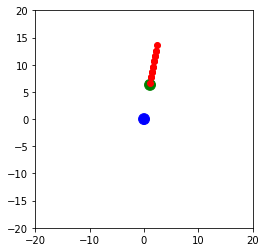

 14%|█▍        | 2797/20000 [01:02<06:28, 44.27it/s]

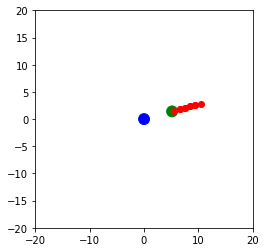

 14%|█▍        | 2899/20000 [01:05<05:57, 47.78it/s]

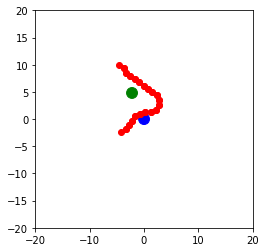

 15%|█▍        | 2996/20000 [01:07<06:53, 41.15it/s]

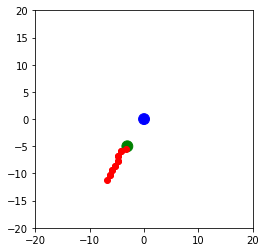

 15%|█▌        | 3098/20000 [01:09<06:08, 45.86it/s]

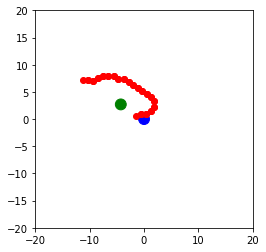

 16%|█▌        | 3198/20000 [01:12<05:52, 47.65it/s]

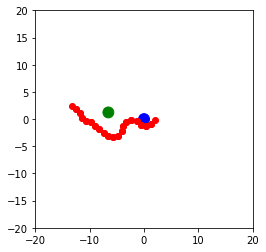

 16%|█▋        | 3296/20000 [01:14<06:04, 45.77it/s]

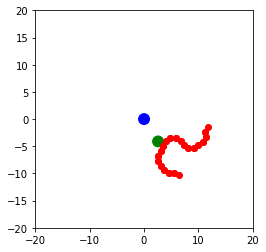

 17%|█▋        | 3394/20000 [01:16<05:39, 48.93it/s]

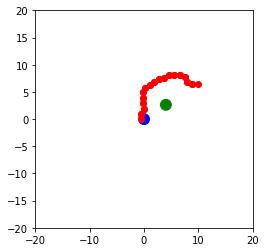

 17%|█▋        | 3495/20000 [01:19<06:39, 41.32it/s]

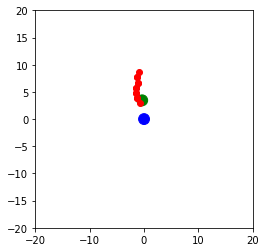

 18%|█▊        | 3599/20000 [01:21<05:20, 51.21it/s]

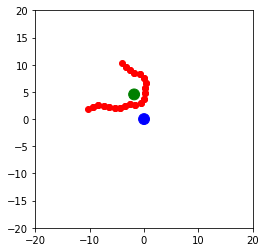

 18%|█▊        | 3697/20000 [01:23<05:18, 51.17it/s]

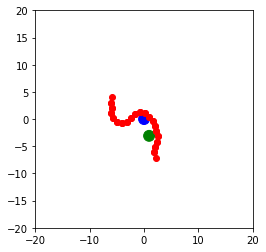

 19%|█▉        | 3800/20000 [01:25<05:11, 52.02it/s]

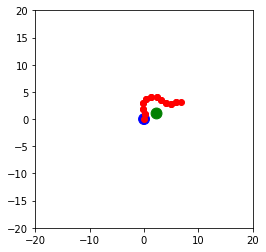

 19%|█▉        | 3897/20000 [01:28<06:14, 42.96it/s]

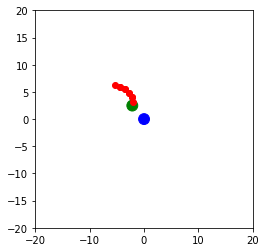

 20%|█▉        | 3999/20000 [01:30<06:00, 44.35it/s]

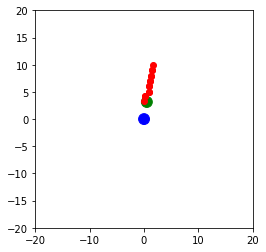

 20%|██        | 4099/20000 [01:37<12:15, 21.62it/s]

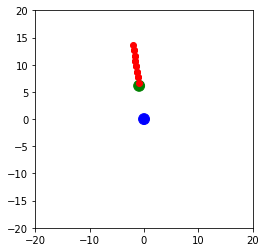

 21%|██        | 4200/20000 [01:41<07:08, 36.85it/s]

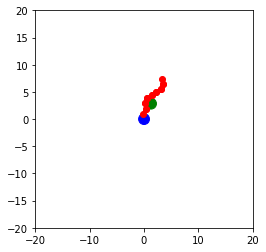

 21%|██▏       | 4296/20000 [01:44<06:36, 39.57it/s]

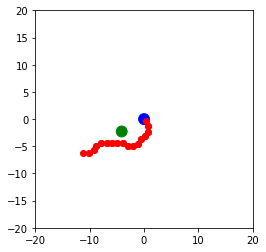

 22%|██▏       | 4395/20000 [01:46<05:31, 47.09it/s]

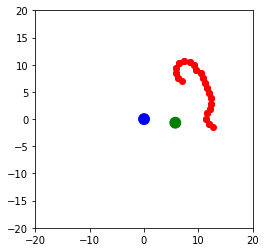

 22%|██▎       | 4500/20000 [01:49<06:37, 38.97it/s]

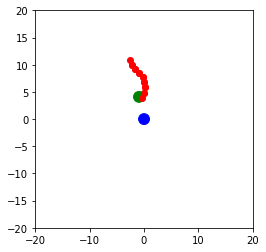

 23%|██▎       | 4595/20000 [01:51<05:06, 50.30it/s]

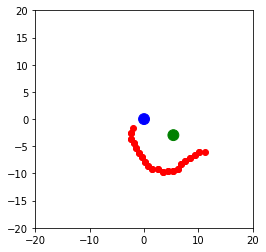

 23%|██▎       | 4698/20000 [01:54<04:56, 51.53it/s]

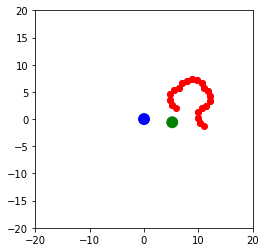

 24%|██▍       | 4799/20000 [01:56<04:52, 51.97it/s]

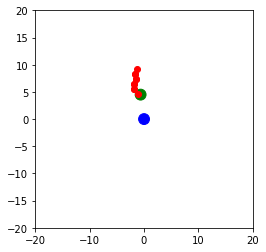

 24%|██▍       | 4899/20000 [01:58<05:06, 49.28it/s]

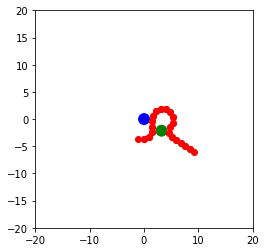

 25%|██▍       | 4997/20000 [02:00<05:05, 49.18it/s]

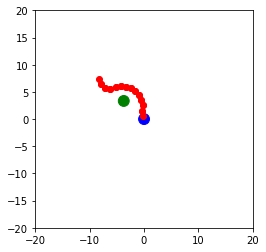

 25%|██▌       | 5095/20000 [02:03<04:59, 49.76it/s]

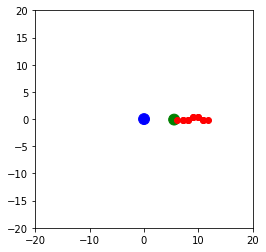

 26%|██▌       | 5194/20000 [02:05<04:10, 59.20it/s]

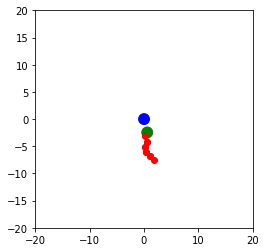

 26%|██▋       | 5296/20000 [02:06<04:16, 57.26it/s]

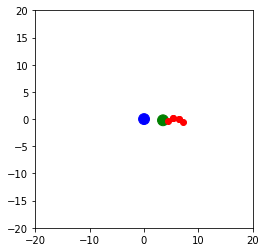

 27%|██▋       | 5398/20000 [02:08<03:48, 63.95it/s]

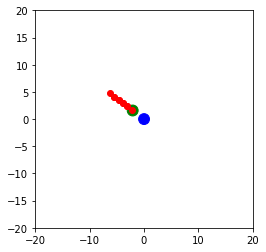

 28%|██▊       | 5500/20000 [02:11<04:40, 51.75it/s]

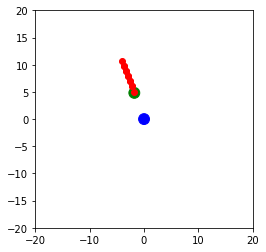

 28%|██▊       | 5600/20000 [02:12<03:42, 64.84it/s]

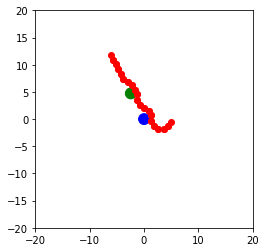

 28%|██▊       | 5698/20000 [02:14<03:48, 62.65it/s]

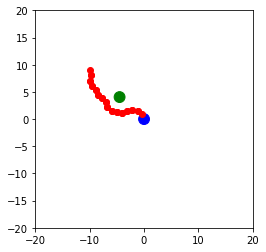

 29%|██▉       | 5795/20000 [02:16<03:37, 65.25it/s]

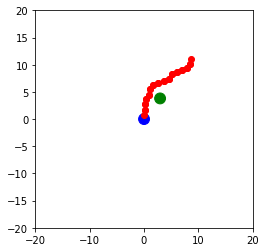

 29%|██▉       | 5898/20000 [02:18<04:02, 58.09it/s]

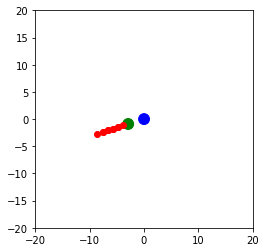

 30%|██▉       | 5994/20000 [02:19<03:43, 62.67it/s]

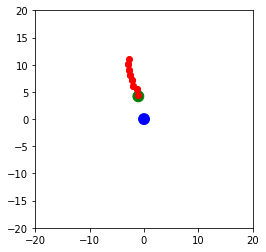

 30%|███       | 6096/20000 [02:21<03:50, 60.45it/s]

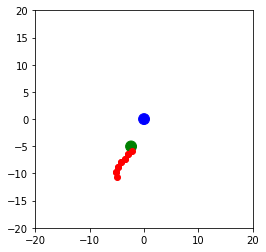

 31%|███       | 6196/20000 [02:23<03:32, 64.99it/s]

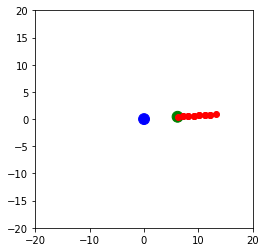

 31%|███▏      | 6297/20000 [02:25<03:30, 65.02it/s]

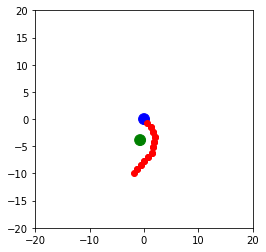

 32%|███▏      | 6400/20000 [02:27<04:31, 50.07it/s]

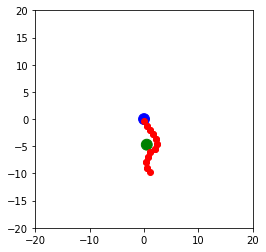

 32%|███▎      | 6500/20000 [02:29<04:46, 47.07it/s]

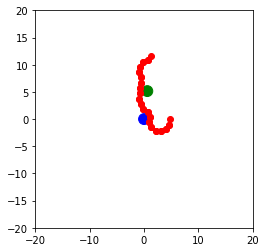

 33%|███▎      | 6600/20000 [02:31<03:31, 63.39it/s]

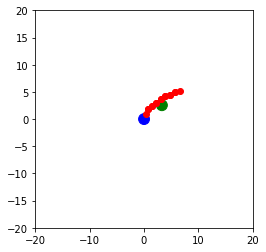

 33%|███▎      | 6697/20000 [02:33<03:44, 59.22it/s]

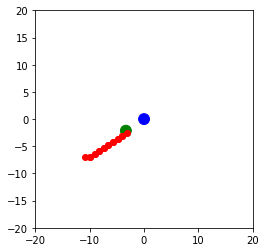

 34%|███▍      | 6793/20000 [02:35<03:38, 60.49it/s]

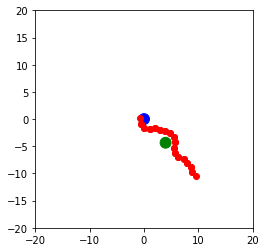

 34%|███▍      | 6898/20000 [02:37<03:33, 61.34it/s]

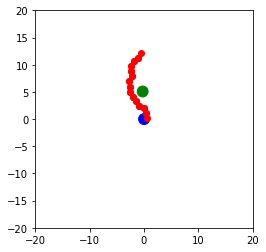

 35%|███▍      | 6996/20000 [02:38<03:27, 62.82it/s]

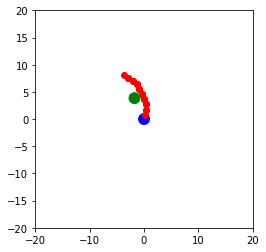

 35%|███▌      | 7096/20000 [02:40<03:55, 54.89it/s]

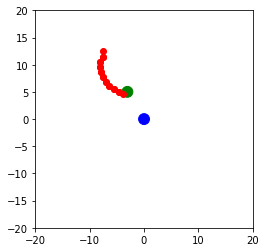

 36%|███▌      | 7196/20000 [02:42<03:44, 57.12it/s]

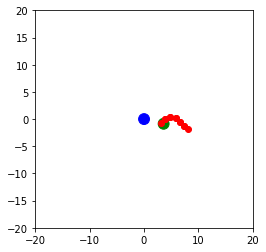

 36%|███▋      | 7300/20000 [02:44<02:58, 71.01it/s]

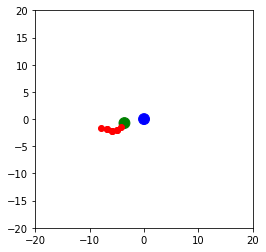

 37%|███▋      | 7397/20000 [02:46<03:55, 53.50it/s]

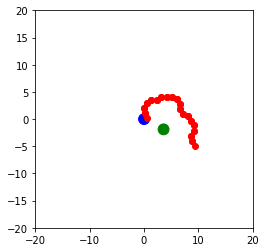

 37%|███▋      | 7495/20000 [02:48<03:36, 57.73it/s]

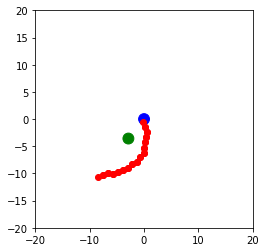

 38%|███▊      | 7599/20000 [02:49<03:30, 59.05it/s]

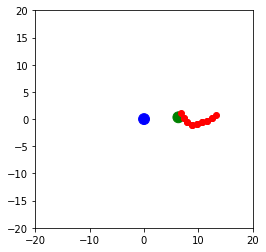

 38%|███▊      | 7700/20000 [02:52<04:00, 51.05it/s]

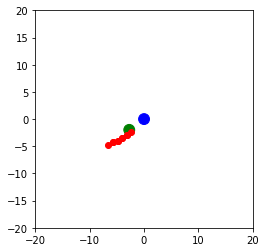

 39%|███▉      | 7797/20000 [02:53<02:53, 70.32it/s]

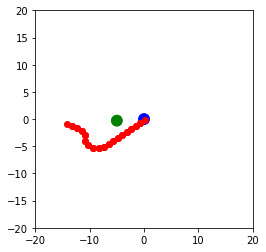

 39%|███▉      | 7894/20000 [02:55<02:53, 69.72it/s]

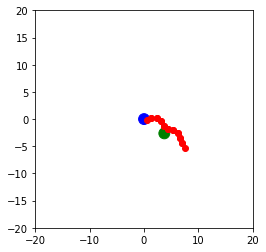

 40%|███▉      | 7999/20000 [02:57<03:11, 62.63it/s]

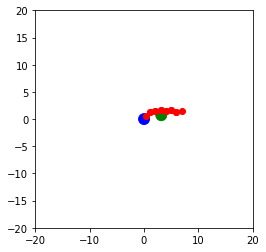

 40%|████      | 8094/20000 [02:59<03:45, 52.81it/s]

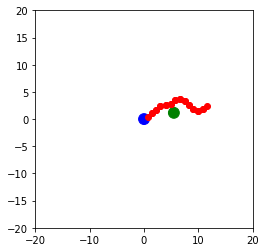

 41%|████      | 8199/20000 [03:00<02:53, 68.16it/s]

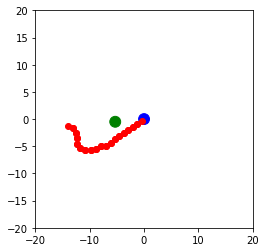

 41%|████▏     | 8299/20000 [03:02<03:25, 56.93it/s]

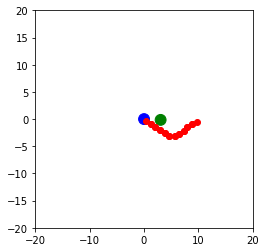

 42%|████▏     | 8396/20000 [03:04<03:03, 63.30it/s]

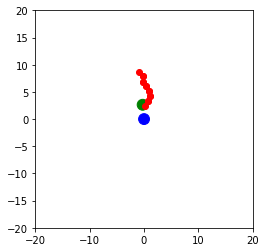

 42%|████▏     | 8495/20000 [03:06<03:15, 58.93it/s]

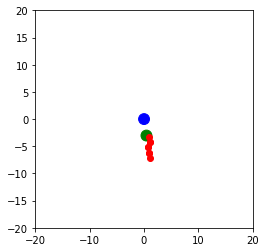

 43%|████▎     | 8599/20000 [03:08<03:03, 62.26it/s]

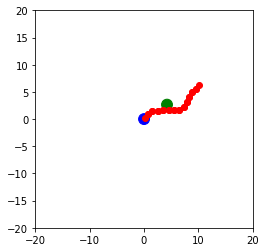

 43%|████▎     | 8699/20000 [03:09<03:25, 55.07it/s]

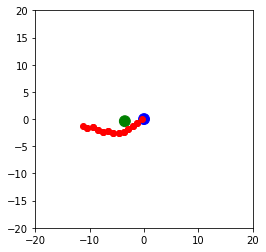

 44%|████▍     | 8797/20000 [03:11<03:06, 60.01it/s]

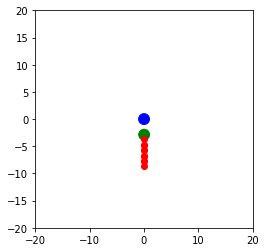

 44%|████▍     | 8895/20000 [03:13<02:56, 62.96it/s]

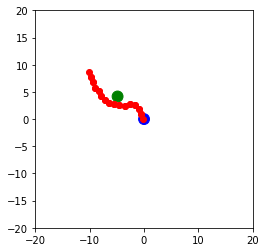

 45%|████▍     | 8996/20000 [03:15<03:45, 48.78it/s]

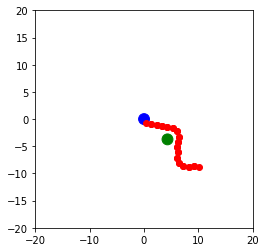

 46%|████▌     | 9100/20000 [03:17<03:12, 56.70it/s]

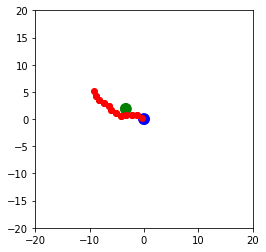

 46%|████▌     | 9197/20000 [03:19<03:04, 58.48it/s]

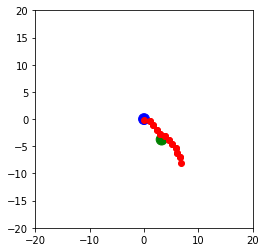

 46%|████▋     | 9294/20000 [03:21<02:49, 63.24it/s]

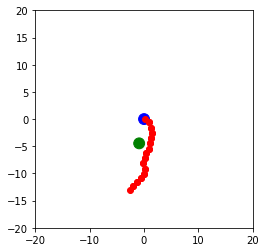

 47%|████▋     | 9396/20000 [03:23<02:53, 61.18it/s]

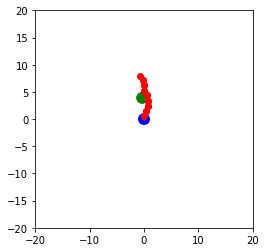

 47%|████▋     | 9494/20000 [03:24<02:56, 59.68it/s]

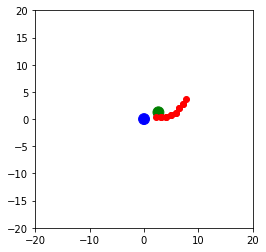

 48%|████▊     | 9598/20000 [03:26<02:55, 59.22it/s]

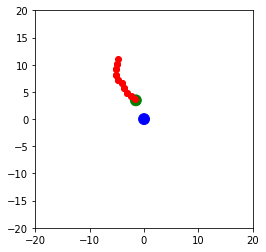

 48%|████▊     | 9694/20000 [03:28<02:57, 58.01it/s]

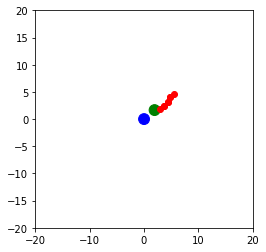

 49%|████▉     | 9798/20000 [03:30<02:50, 59.96it/s]

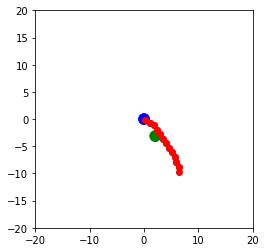

 49%|████▉     | 9895/20000 [03:32<02:50, 59.10it/s]

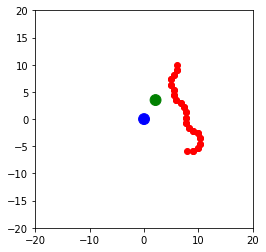

 50%|████▉     | 9998/20000 [03:34<03:11, 52.36it/s]

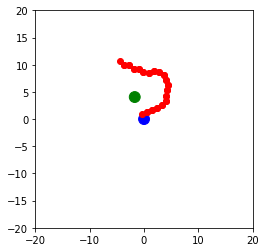

 50%|█████     | 10093/20000 [03:35<02:49, 58.45it/s]

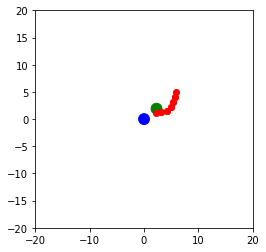

 51%|█████     | 10197/20000 [03:37<02:47, 58.44it/s]

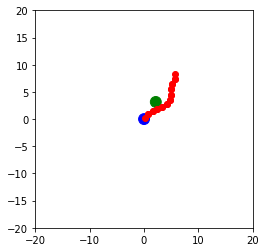

 51%|█████▏    | 10299/20000 [03:39<02:47, 57.97it/s]

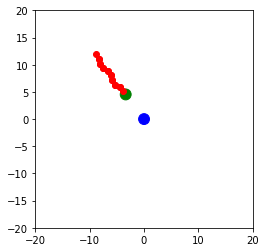

 52%|█████▏    | 10397/20000 [03:41<02:26, 65.71it/s]

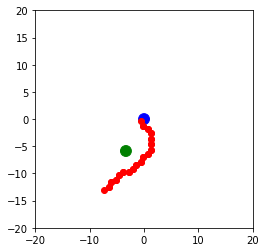

 52%|█████▏    | 10498/20000 [03:42<02:39, 59.76it/s]

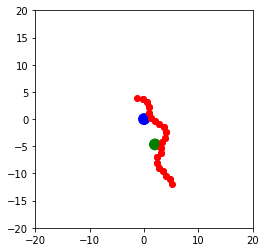

 53%|█████▎    | 10599/20000 [03:44<02:52, 54.40it/s]

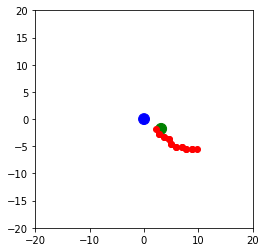

 53%|█████▎    | 10697/20000 [03:46<02:30, 61.97it/s]

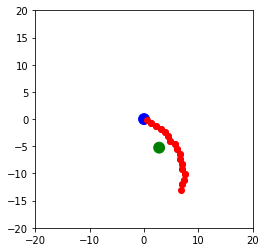

 54%|█████▍    | 10798/20000 [03:48<02:22, 64.40it/s]

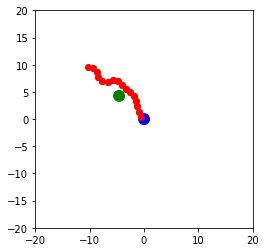

 55%|█████▍    | 10900/20000 [03:50<02:30, 60.52it/s]

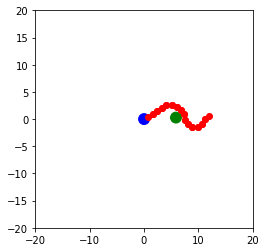

 55%|█████▍    | 10996/20000 [03:52<02:37, 57.00it/s]

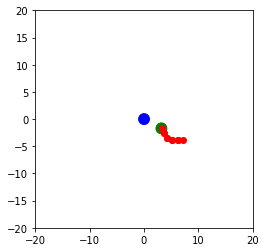

 55%|█████▌    | 11097/20000 [03:54<02:40, 55.59it/s]

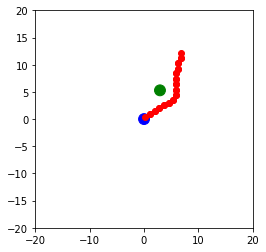

 56%|█████▌    | 11198/20000 [03:56<02:48, 52.21it/s]

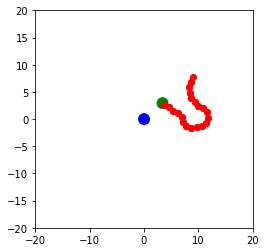

 56%|█████▋    | 11295/20000 [03:58<02:39, 54.69it/s]

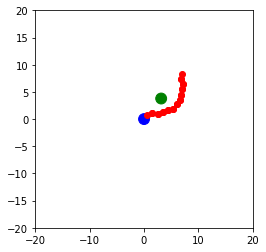

 57%|█████▋    | 11397/20000 [04:00<02:21, 60.98it/s]

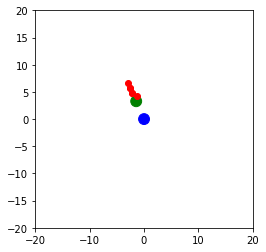

 57%|█████▋    | 11496/20000 [04:02<02:31, 56.27it/s]

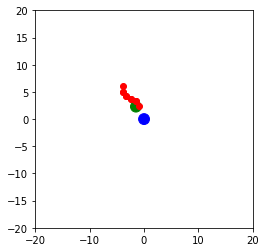

 58%|█████▊    | 11600/20000 [04:04<02:09, 65.09it/s]

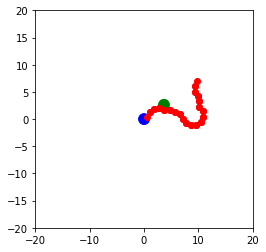

 58%|█████▊    | 11693/20000 [04:06<01:57, 70.53it/s]

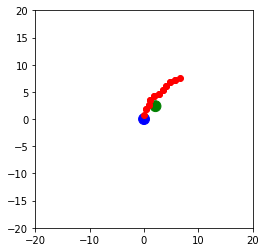

 59%|█████▉    | 11799/20000 [04:08<02:27, 55.78it/s]

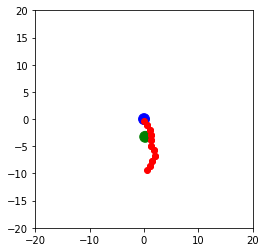

 59%|█████▉    | 11899/20000 [04:10<02:31, 53.64it/s]

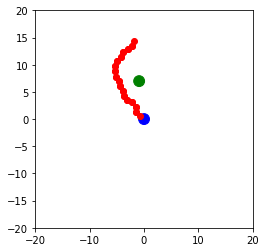

 60%|█████▉    | 11999/20000 [04:11<02:22, 56.01it/s]

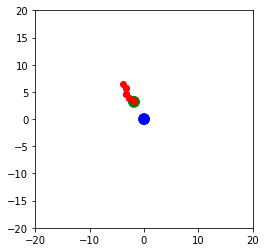

 60%|██████    | 12095/20000 [04:13<02:21, 55.96it/s]

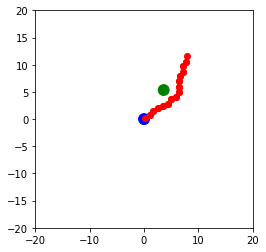

 61%|██████    | 12196/20000 [04:15<02:09, 60.32it/s]

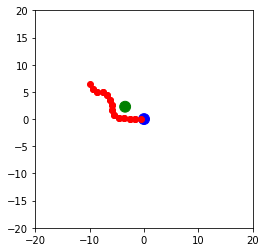

 61%|██████▏   | 12295/20000 [04:17<01:58, 65.11it/s]

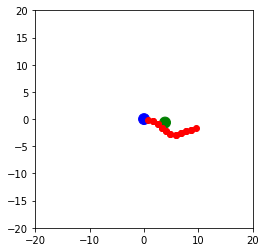

 62%|██████▏   | 12395/20000 [04:19<02:03, 61.80it/s]

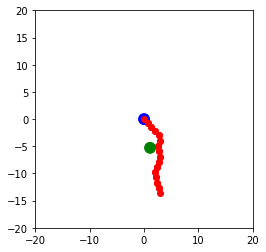

 62%|██████▏   | 12497/20000 [04:21<02:42, 46.26it/s]

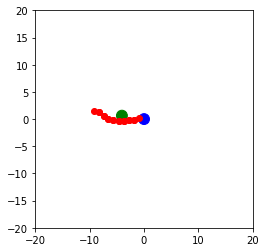

 63%|██████▎   | 12598/20000 [04:23<02:09, 57.36it/s]

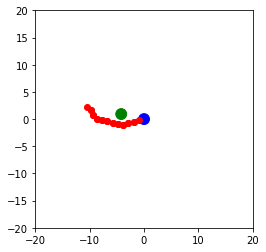

 64%|██████▎   | 12700/20000 [04:24<02:07, 57.48it/s]

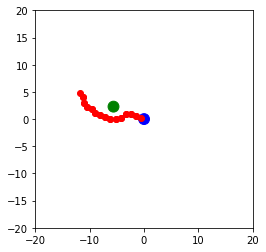

 64%|██████▍   | 12798/20000 [04:26<02:09, 55.41it/s]

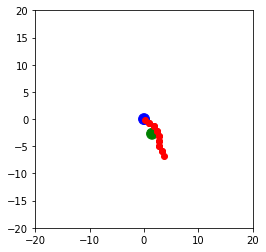

 64%|██████▍   | 12895/20000 [04:28<01:54, 61.90it/s]

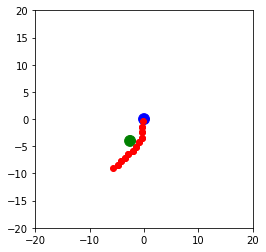

 65%|██████▍   | 12996/20000 [04:30<01:54, 60.97it/s]

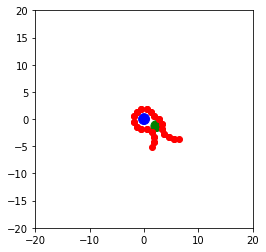

 65%|██████▌   | 13095/20000 [04:31<01:44, 65.97it/s]

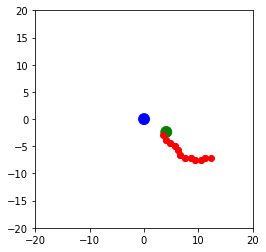

 66%|██████▌   | 13198/20000 [04:34<02:01, 55.78it/s]

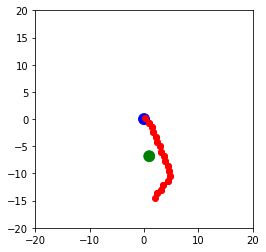

 66%|██████▋   | 13293/20000 [04:35<01:54, 58.61it/s]

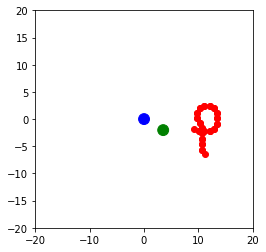

 67%|██████▋   | 13400/20000 [04:37<01:42, 64.43it/s]

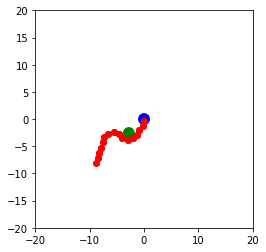

 67%|██████▋   | 13498/20000 [04:39<01:43, 62.99it/s]

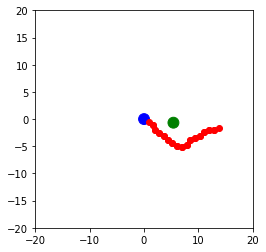

 68%|██████▊   | 13596/20000 [04:41<01:37, 65.44it/s]

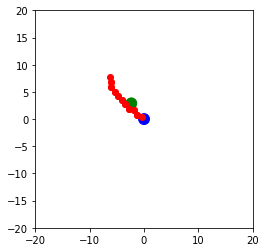

 68%|██████▊   | 13699/20000 [04:42<01:47, 58.64it/s]

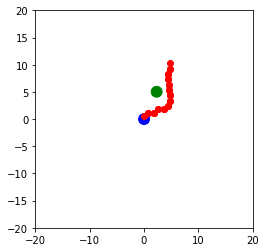

 69%|██████▉   | 13800/20000 [04:44<02:12, 46.68it/s]

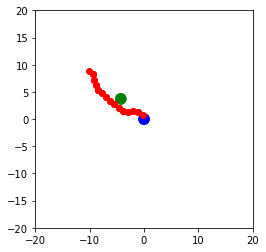

 69%|██████▉   | 13898/20000 [04:46<01:48, 56.17it/s]

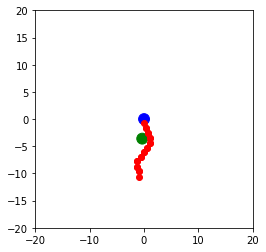

 70%|███████   | 14000/20000 [04:48<01:46, 56.20it/s]

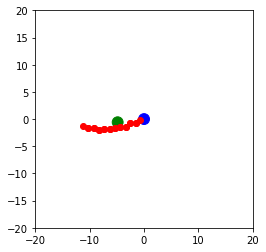

 70%|███████   | 14096/20000 [04:50<01:42, 57.41it/s]

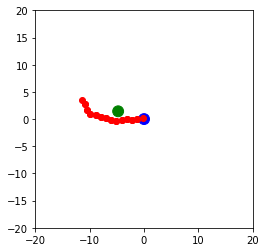

 71%|███████   | 14197/20000 [04:52<01:41, 57.32it/s]

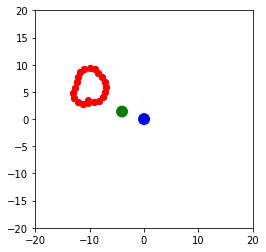

 71%|███████▏  | 14299/20000 [04:54<01:43, 54.91it/s]

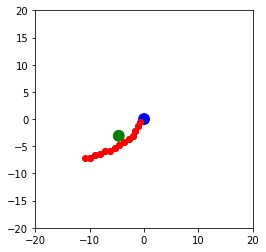

 72%|███████▏  | 14394/20000 [04:55<01:22, 67.69it/s]

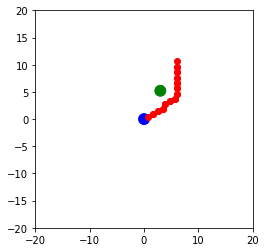

 72%|███████▏  | 14499/20000 [04:57<01:39, 55.38it/s]

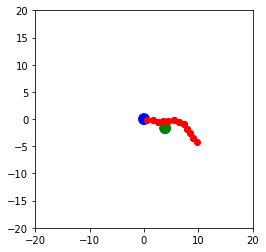

 73%|███████▎  | 14597/20000 [04:59<01:24, 63.70it/s]

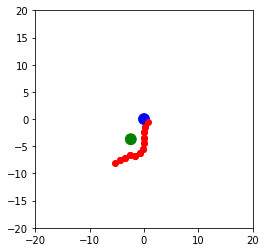

 73%|███████▎  | 14695/20000 [05:01<01:21, 64.99it/s]

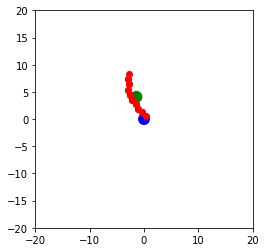

 74%|███████▍  | 14797/20000 [05:03<01:26, 59.82it/s]

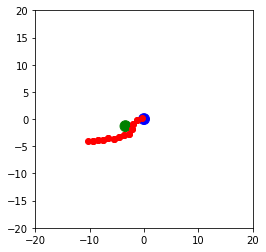

 74%|███████▍  | 14898/20000 [05:04<01:15, 67.47it/s]

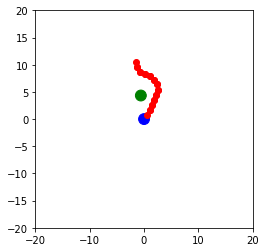

 75%|███████▌  | 15000/20000 [05:06<01:16, 65.69it/s]

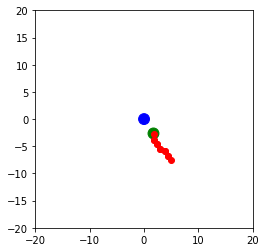

 75%|███████▌  | 15098/20000 [05:08<01:23, 58.79it/s]

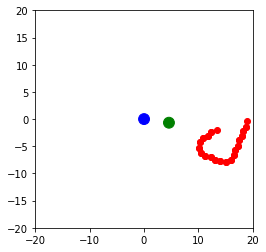

 76%|███████▌  | 15194/20000 [05:09<01:12, 66.61it/s]

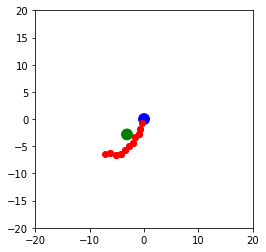

 76%|███████▋  | 15294/20000 [05:11<01:14, 63.53it/s]

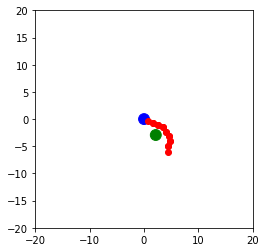

 77%|███████▋  | 15398/20000 [05:13<01:33, 49.02it/s]

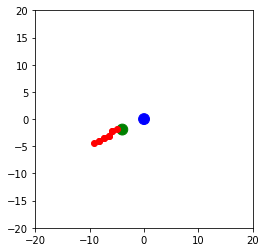

 77%|███████▋  | 15498/20000 [05:15<01:15, 59.58it/s]

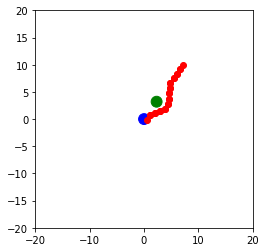

 78%|███████▊  | 15595/20000 [05:17<01:12, 60.57it/s]

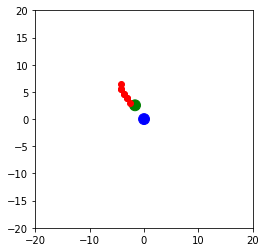

 78%|███████▊  | 15700/20000 [05:19<01:08, 62.73it/s]

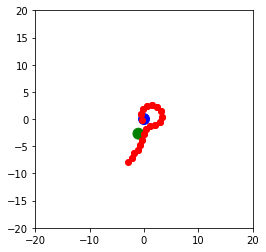

 79%|███████▉  | 15798/20000 [05:21<01:06, 62.75it/s]

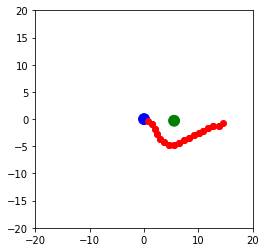

 79%|███████▉  | 15896/20000 [05:23<01:15, 54.32it/s]

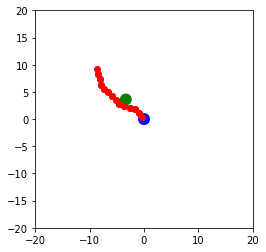

 80%|███████▉  | 15998/20000 [05:25<01:06, 59.95it/s]

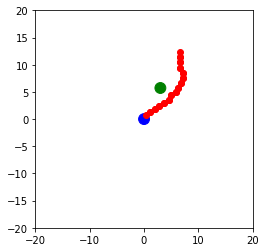

 80%|████████  | 16100/20000 [05:26<01:03, 61.60it/s]

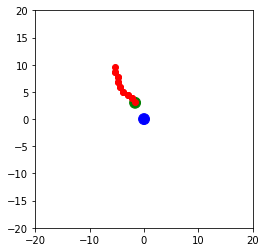

 81%|████████  | 16198/20000 [05:28<01:00, 62.65it/s]

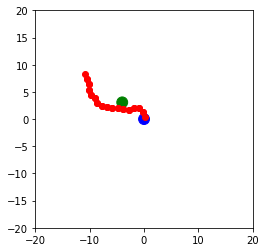

 81%|████████▏ | 16296/20000 [05:30<01:01, 60.14it/s]

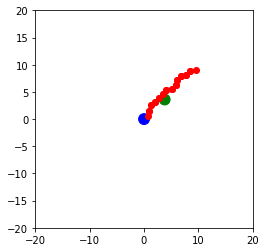

 82%|████████▏ | 16399/20000 [05:32<01:02, 57.53it/s]

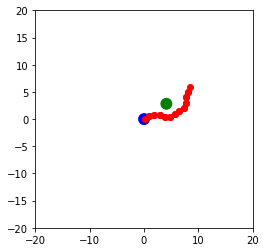

 82%|████████▏ | 16494/20000 [05:33<00:54, 64.32it/s]

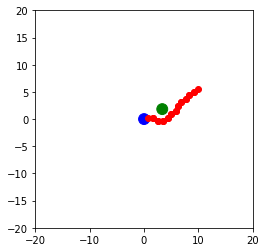

 83%|████████▎ | 16594/20000 [05:37<01:00, 56.35it/s]

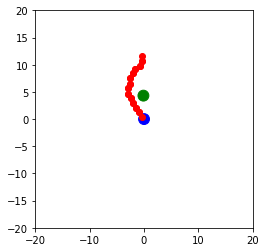

 83%|████████▎ | 16699/20000 [05:39<00:57, 57.40it/s]

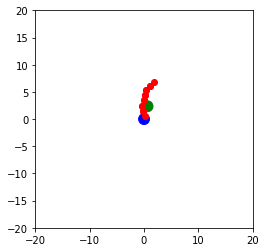

 84%|████████▍ | 16800/20000 [05:41<01:13, 43.82it/s]

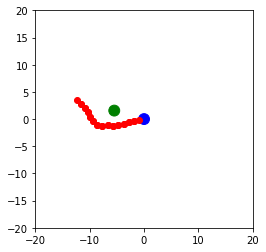

 84%|████████▍ | 16900/20000 [05:43<00:55, 55.45it/s]

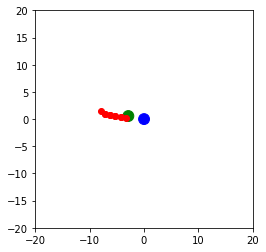

 85%|████████▍ | 16996/20000 [05:45<00:47, 63.24it/s]

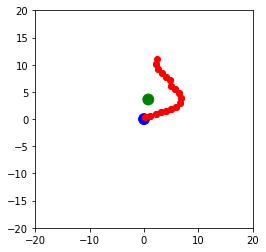

 85%|████████▌ | 17099/20000 [05:47<00:47, 61.46it/s]

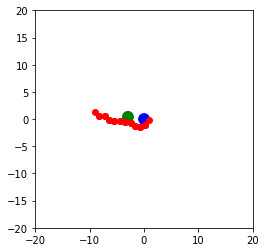

 86%|████████▌ | 17199/20000 [05:49<01:08, 40.71it/s]

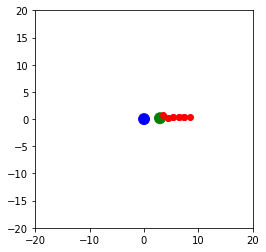

 86%|████████▋ | 17295/20000 [05:51<00:47, 57.37it/s]

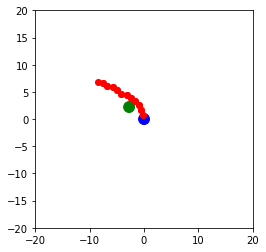

 87%|████████▋ | 17395/20000 [05:53<00:44, 58.50it/s]

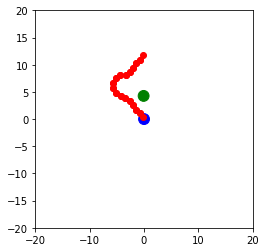

 87%|████████▋ | 17494/20000 [05:55<00:40, 61.55it/s]

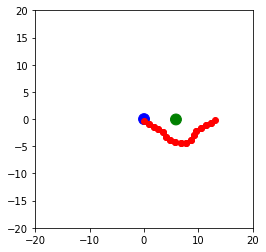

 88%|████████▊ | 17596/20000 [05:57<00:37, 64.61it/s]

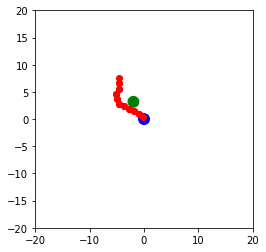

 88%|████████▊ | 17697/20000 [05:59<00:37, 61.18it/s]

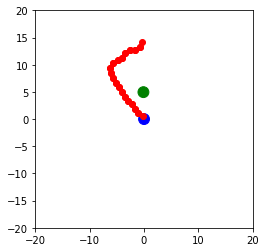

 89%|████████▉ | 17800/20000 [06:01<00:37, 57.91it/s]

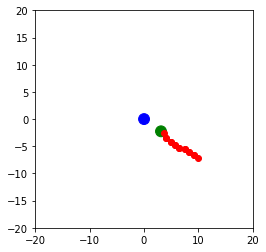

 89%|████████▉ | 17894/20000 [06:02<00:33, 62.51it/s]

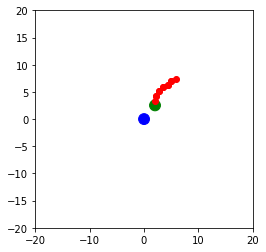

 90%|████████▉ | 17997/20000 [06:04<00:32, 61.72it/s]

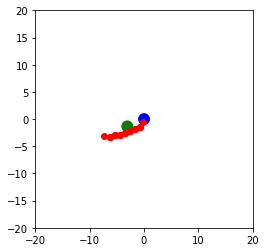

 90%|█████████ | 18100/20000 [06:06<00:33, 56.06it/s]

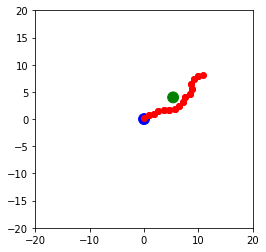

 91%|█████████ | 18200/20000 [06:08<00:36, 48.94it/s]

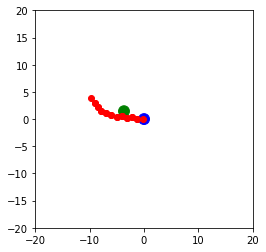

 91%|█████████▏| 18299/20000 [06:10<00:31, 54.29it/s]

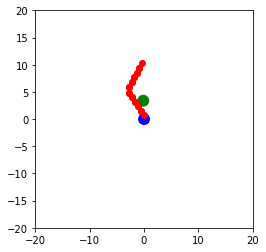

 92%|█████████▏| 18400/20000 [06:12<00:26, 60.21it/s]

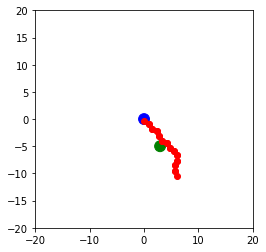

 92%|█████████▎| 18500/20000 [06:14<00:28, 52.05it/s]

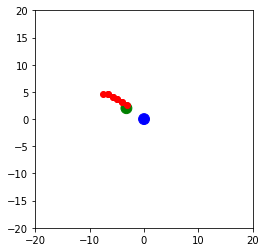

 93%|█████████▎| 18597/20000 [06:16<00:24, 58.25it/s]

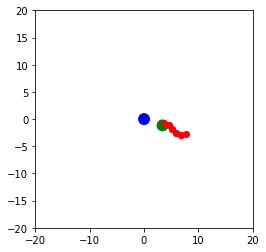

 93%|█████████▎| 18697/20000 [06:17<00:23, 55.10it/s]

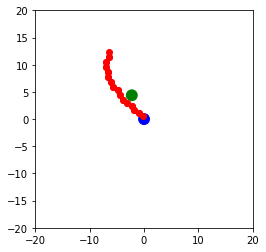

 94%|█████████▍| 18796/20000 [06:19<00:22, 53.42it/s]

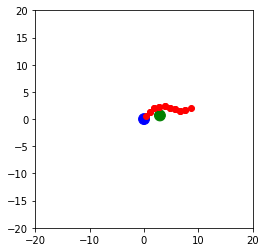

 94%|█████████▍| 18893/20000 [06:21<00:18, 60.97it/s]

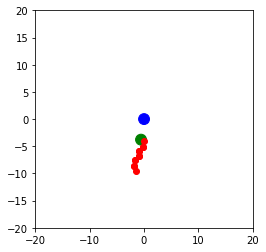

 95%|█████████▍| 18995/20000 [06:23<00:17, 56.57it/s]

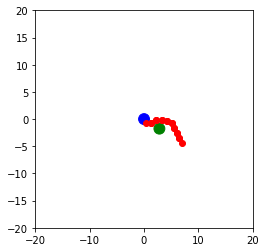

 95%|█████████▌| 19096/20000 [06:25<00:15, 57.85it/s]

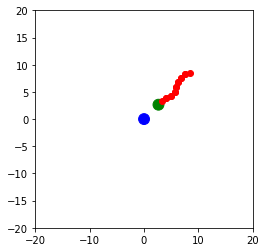

 96%|█████████▌| 19196/20000 [06:26<00:11, 72.45it/s]

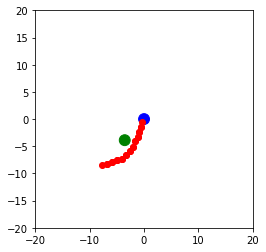

 96%|█████████▋| 19296/20000 [06:28<00:09, 71.41it/s]

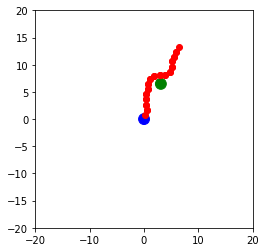

 97%|█████████▋| 19393/20000 [06:30<00:09, 60.91it/s]

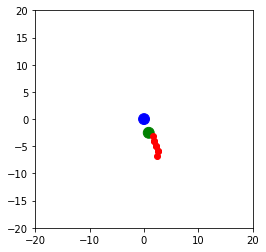

 97%|█████████▋| 19496/20000 [06:32<00:09, 52.42it/s]

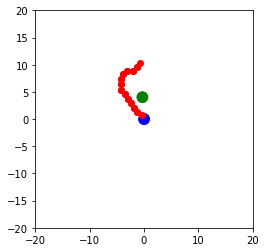

 98%|█████████▊| 19594/20000 [06:33<00:06, 65.68it/s]

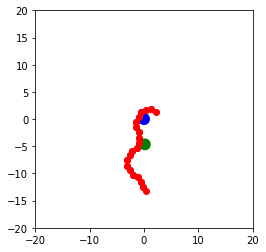

 98%|█████████▊| 19695/20000 [06:35<00:05, 55.34it/s]

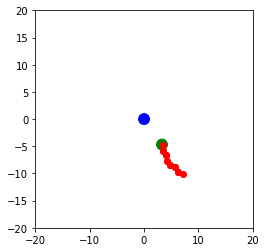

 99%|█████████▉| 19797/20000 [06:37<00:03, 53.21it/s]

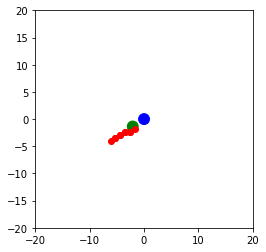

 99%|█████████▉| 19896/20000 [06:39<00:01, 56.57it/s]

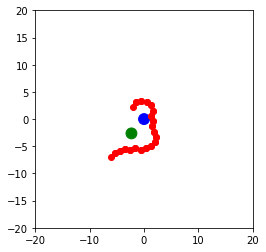

100%|██████████| 20000/20000 [06:41<00:00, 49.79it/s]


In [16]:
rewards = []
net = DQN()

def main():
    print("The DQN is collecting experience...")
    step_counter_list = []
    for episode in tqdm.tqdm(range(EPISODES)):
        state = env.reset()
        step_counter = 0
        sum_rew = 0
        while True:
            step_counter +=1
            action = net.choose_action(state)
            next_state, reward, done = env.step(action)
            sum_rew += reward
            net.store_trans(state, action, reward, next_state)
            if net.memory_counter >= MEMORY_CAPACITY:
                net.learn()
            if done:
                step_counter_list.append(step_counter)
                rewards.append(sum_rew)
                if episode % 100 == 0:
                    env.draw_map()
                break

            state = next_state


if __name__ == '__main__':
    main()

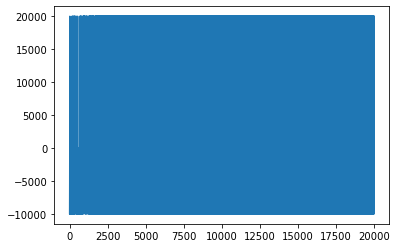

In [17]:
import matplotlib.pyplot as plt

plt.plot(rewards)

In [18]:
p = 0
for i in rewards:
    if i > 0:
        p += 1

print(p)

11422
